# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Problem Statement

* We will be exploring the Starbuck’s Dataset which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. 
* There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a required amount that the user is expected to spend. Offers can be delivered via multiple channels.
* We will aim to find an answer to the following questions in this notebook.
 1. What is the proportion of client who have completed the offers based on Sex?
 2. What is the proportion of client who have completed the offers based on their income level?
 3. What are the most important features that help drive the offers in customers?
 


## Strategy 

* First, I will wrangle and combine the data from offer portfolio, customer profile, and transaction. After which I can merge all the table into one for analysis.
* Secondly, I will work on visualization to provide answers to the questions 1 and 2.
* Finally, I will move on to find the important feature driver for the offers. I plan to test out few models(like, Decision Tree Classifier, Gaussian NB and Random Forest Classifier) before applying one as a fixed solution and provide visualization for the important feature drivers.


## Metrics
I will use accuracy and F-score metrics for comparision and to test out the performance of the models.   
Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".

## Table of Contents
* ### [Table Exploration(Portfolio, Profile, Transcript)](#tableexp)
* ### [Data Cleaning for Tables](#dataclean)
* ### [Preparing Table for analysis](#preptable)
* ### [Data Exploration](#dataexp)
* ### [Evaluating Model](#evmodel)
* ### [Conclusion](#conclusion)

  

## Importing

In [3]:
import sys
!{sys.executable} -m pip install progressbar 

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [5]:
print(sys.version)

3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [4]:
import pandas as pd
import numpy as np
import progressbar
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from time import time
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

<a name="tableexp"></a>
# <span style="color:blue"> Table Exploration (Portfolio, Profile, Transcript)</span>

## Portfolio

In [10]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [11]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


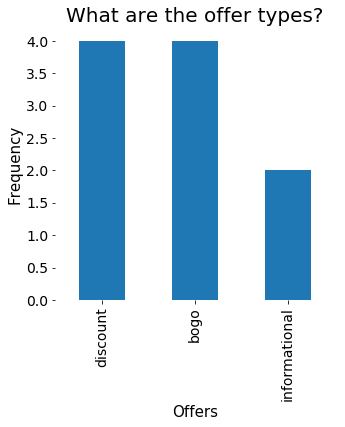

In [14]:
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("What are the offer types?", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

We can see from above that the portfolio table consists of 10 not-null entries  that contains information about the offers provided by starbucks. It has channels through which the specific offers are deployed which consists of elements in a list, which has to be handled later in the process.   
Finally, We can see a histogram containing a distribution of 3 offer types totalling in 10 entries.   
This table needs to be cleaned, which will be done in the next phase.

## Profile

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


---

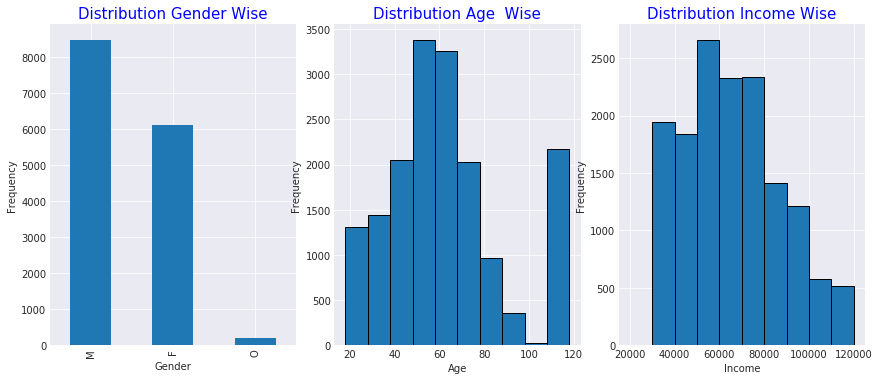

In [58]:
#Creating Subplots for distribution based on Gender,Age and Income
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
profile.gender.value_counts().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
profile.age.plot.hist(ax=ax[1],fontsize=10,edgecolor='black') 
ax[1].set_title("Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
profile.income.plot.hist(ax=ax[2],fontsize=10,edgecolor='black',range=(20000, 120000)) 
ax[2].set_title("Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()


We can see from above that the profile table consists of 17000 entries with some null elements in the columns gender and income.   
Also, from the dashboard above we can see the distribution of the members according to the gender, age and income.   
We can also see that in respect to the distribution according to the gender, frequency of male is more than the female with little population towards others.   
Secondly, while looking at age wise distribution it is evident that the age group from 50-70 is the highest.   
Finally, while looking at the income wise distribution, member with income ranging from 40k- 80k  are high than others.
We need to clean this profile table as it contains nll values as well as age value oof 118 which has a  lot of frequency and it is due to some data entry error. 

## Transcript 

In [60]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [61]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


We can see that this table consists of 306534 entries which is all populated and contains no null values. However, this table needs to be cleaned and offer should be extracted based on the id while simulataneously classifying it based on the completion,view, and received. This will be done in the data cleaning phase.

---

<a name="dataclean"></a>
# <span style="color:blue"> Data Cleaning for Tables </span>

## Data Cleaning for Portfolio

In [68]:
def clean_portfolio(df=portfolio):
    """
    Takes the dataframe portfolio and cleans it by creating one-hot encodings.
    
    PARAMETERS:
        portfolio dataframe
        
    RETURNS:
        A new dataframe consisting of:
        - One-hot encoded channels column
        - One-hot encoded offer_type column   
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
    
    # One-hot encode channels column
    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    # One-hot encode offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # Concat one-hot and df
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    return new_df

In [64]:
cleaned_portfolio= clean_portfolio() 
cleaned_portfolio

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


## Data Cleaning for Profile

In [69]:
def clean_profile(profile = profile):
    """
    Takes the dataframe profile and cleans it by creating one-hot encodings as well as handling null values and  error age value 118.
    
    PARAMETERS:
        Profile dataframe.
        
    RETURNS:
        A new dataframe whithout income values iqual to null and age iqual to 118 as well as one hot encoded columns.
    """
    # drop lines with income = nan and age == 118
    new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)
    
    # One-hot encode Gender column
    gender_dummies = pd.get_dummies(new_df["gender"])
    
    # Specifying age range and one hot encoding
    range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Specifying income range and one hot encoding
   
    range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    

    # Concat
    new_df = pd.concat([new_df, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)
    
    # Dropping age,gender,income column
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    return new_df

In [71]:
cleaned_profile = clean_profile()
cleaned_profile.head(10)

,became_member_on,id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
13,20170911,aa4862eba776480b8bb9c68455b8c2e1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
14,20140213,e12aeaf2d47d42479ea1c4ac3d8286c6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15,20160211,31dda685af34476cad5bc968bdb01c53,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
16,20141113,62cf5e10845442329191fc246e7bcea3,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
18,20171231,6445de3b47274c759400cd68131d91b4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 24 columns):
became_member_on    14825 non-null int64
id                  14825 non-null object
(18, 20]            14825 non-null uint8
(20, 29]            14825 non-null uint8
(29, 39]            14825 non-null uint8
(39, 49]            14825 non-null uint8
(49, 59]            14825 non-null uint8
(59, 69]            14825 non-null uint8
(69, 79]            14825 non-null uint8
(79, 89]            14825 non-null uint8
(89, 99]            14825 non-null uint8
(99, 102]           14825 non-null uint8
(30000, 40000]      14825 non-null uint8
(40000, 50000]      14825 non-null uint8
(50000, 60000]      14825 non-null uint8
(60000, 70000]      14825 non-null uint8
(70000, 80000]      14825 non-null uint8
(80000, 90000]      14825 non-null uint8
(90000, 100000]     14825 non-null uint8
(100000, 110000]    14825 non-null uint8
(110000, 120000]    14825 non-null uint8
F                   14825 non

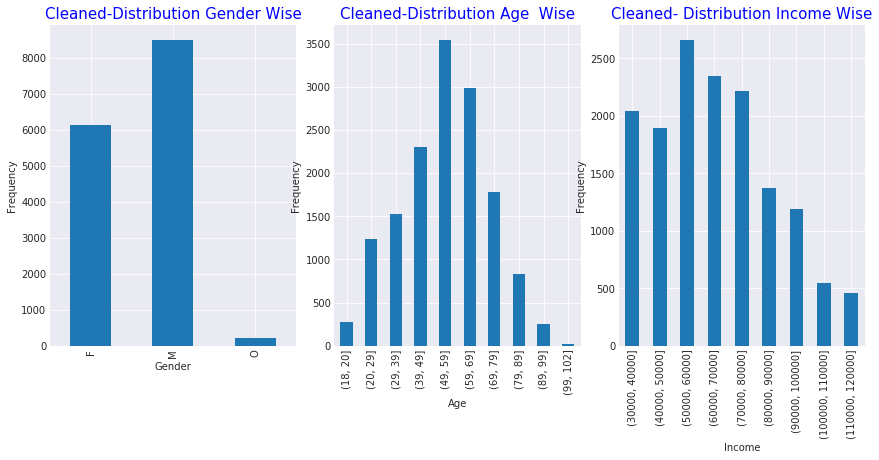

In [76]:
#Creating Subplots for distribution based on Gender,Age and Income for the Newly cleaned Profile data
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
cleaned_profile[cleaned_profile.columns[21:]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Cleaned-Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
cleaned_profile[cleaned_profile.columns[2:12]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Cleaned-Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
cleaned_profile[cleaned_profile.columns[12:21]].sum().plot.bar(ax=ax[2],fontsize=10) 
ax[2].set_title("Cleaned- Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()


We can see the result of the profile charts displayed above after the table has been cleaned.

## Data Cleaning for Transcript

The transcript table consists of value columns which comprises of dictionary values in which the keys are offer id, amount. We need to first extract these keys before we move on to one hot encoding them.

In [86]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_column(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    

In [87]:
def clean_transcript(transcript = transcript):
    """
    Cleans the Transcript table by setting one hot encoding values.
    PARAMETERS:
        transcript dataframe
    
    RETURNS:
        Cleaned transcript  dataframe
    
    """
    #
    transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
    transcript['amount'] = transcript.value.apply(create_amount_column)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    new_df = pd.concat([transcript, event], axis=1, sort=False)
    
    # Create and Drop Transaction
    transaction = new_df[new_df["transaction"]==1]
    new_df = new_df.drop(transaction.index)
    
    # Drop
    new_df = new_df.drop(columns = ["event","value", "amount", "transaction"])
    
    return new_df

In [89]:
cleaned_transcript = clean_transcript()
cleaned_transcript.head(10)

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [90]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
person             167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
dtypes: int64(1), object(2), uint8(3)
memory usage: 5.6+ MB


In [91]:
cleaned_transcript[cleaned_transcript['offer completed']==1].shape

(33579, 6)

<a name="preptable"></a>
# <span style="color:blue"> Preparing Table for Analysis </span>

<a name="dataexp"></a>
# <span style="color:blue">Data Exploration </span>

<a name="evmodel"></a>
# <span style="color:blue">Evaluating Model </span>

<a name="conclusion"></a>
# <span style="color:blue">Conclusion </span>